# pySCENIC on NK cells, MM

Preparation and run Single-Cell rEgulatory Network Inference and Clustering using pySCENIC.

## Why pySCENIC
- A lot of compatibility problems with the R version
- Faster
- I like more python than

After having preparred the environment and the files (look [here](./prepare_env.ipnb))

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
adata = sc.read_h5ad("Data/mm_nk.h5ad")
adata

AnnData object with n_obs × n_vars = 14103 × 48361
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition'

In [3]:
sc.pp.subsample(adata, n_obs=100)

write to an unfiltered loom file

In [4]:
f_loom_path_unfilt = "Data/nk_mm_unfiltered.loom"
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "new_label": np.array(adata.obs.new_label)
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

# basic metrics and filtering:

In [5]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  22945.0
Number of cells in which each gene is detected: 0  -  100


In [6]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  3.0
minSamples:  1.0


In [7]:
adata_copy = adata.copy()

# initial cuts
sc.pp.filter_cells(adata_copy, min_genes=200 )
sc.pp.filter_genes(adata_copy, min_cells=10)
sc.pp.filter_genes(adata_copy, min_counts=10)

adata_copy

AnnData object with n_obs × n_vars = 100 × 3874
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition', 'n_genes'
    var: 'n_cells', 'n_counts'

In [8]:
f_loom_path_scenic = "Data/nk_mm_scenic.loom"

# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)



## Scenic


### STEP 1: Gene regulatory network inference, and generation of co-expression modules
Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used.


In [9]:
tfs = "databases/allTFs_hg38.txt"

In [10]:
!pyscenic grn {f_loom_path_scenic} {tfs} -o Results/adj.csv --num_workers 8 --seed 123 1> grn.log 2> grn.err


2023-02-15 20:30:47,629 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-02-15 20:30:47,706 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
2023-02-15 20:30:57,233 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-sx1zfrou', purging
2023-02-15 20:30:57,234 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-esnk7kva', purging
2023-02-15 20:30:57,234 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7k1w5r28', purging
2023-02-15 20:30:57,234 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zfa654j_', purging
2023-02-15 20:30:57,234 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-o_r0dd2g', purging
2023-02-15 20:30:57,235 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-

In [12]:
adjacencies = pd.read_csv("Results/adj.csv", index_col=False, sep='\t')
adjacencies.head()

,"TF,target,importance"
0,"RPS10,RPLP1,64.34993328309977"
1,"RPS10,RPS27,60.317838694208135"
2,"RPS10,RPS27A,52.74881588434809"
3,"RPS10,RPS21,51.17672503135639"
4,"TPI1,GAPDH,50.63652818543953"


In [13]:
import glob
# ranking databases
f_db_glob = "databases/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "databases/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl"

In [15]:
!pyscenic ctx Results/adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output Results/reg.csv \
    --mask_dropouts \
    --num_workers 8 \
    1> ctx.log 2> ctx.err


2023-02-16 08:28:21,204 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-02-16 08:28:21,501 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-02-16 08:28:21,585 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-02-16 08:28:21,700 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-02-16 08:28:23,735 - pyscenic.utils - INFO - Creating modules.

2023-02-16 08:28:37,154 - pyscenic.cli.pyscenic - IN

In [46]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(adata_copy.X>0, axis=1).flatten().tolist()).T
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

            0
0.01   207.73
0.05   366.50
0.10   453.40
0.50   888.00
1.00  1862.00


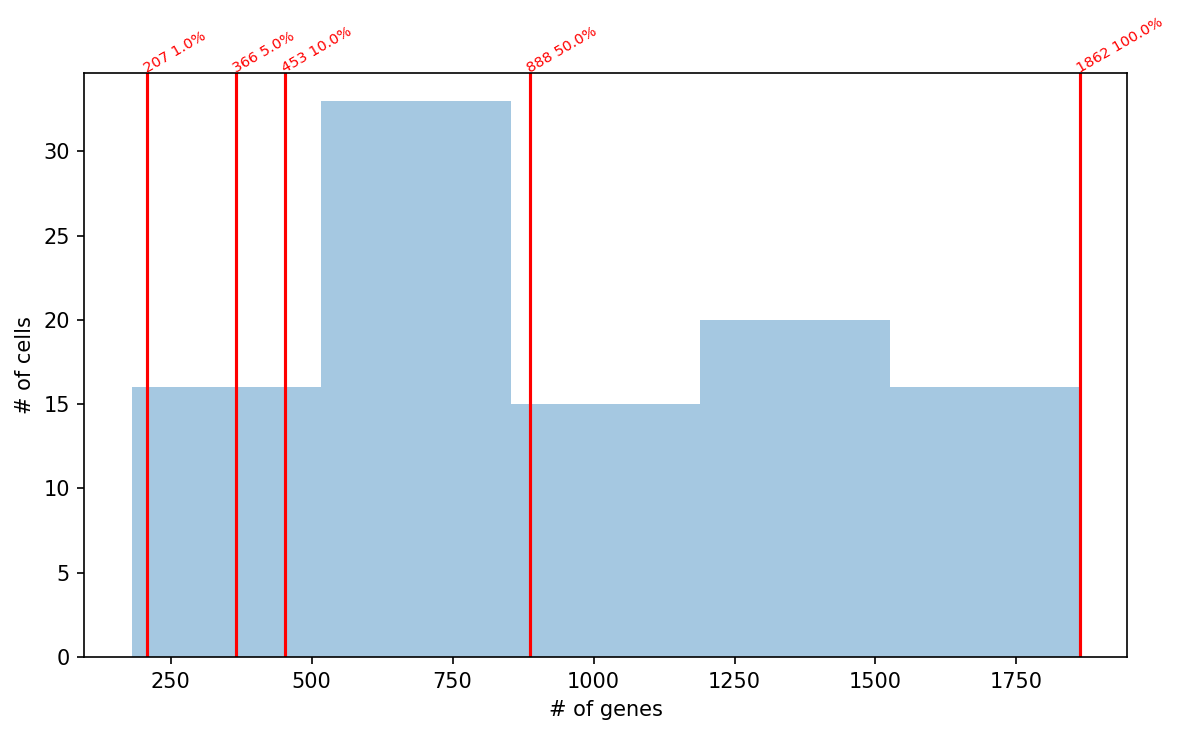

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in percentiles.iterrows():
    fig.gca().axvline(x=x[0], ymin=0,ymax=1, color='red')
    ax.text(x=x[0], y=ax.get_ylim()[1], s=f'{int(x[0])} {i*100}%', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [65]:
f_pyscenic_output = "Results/pyscenic_output.loom"

In [66]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    Results/reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 8 \
     1> aucell.log 2> aucell.err


2023-02-16 09:57:00,062 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-02-16 09:57:00,131 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-02-16 09:57:00,506 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-02-16 09:57:04,580 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/home/jacopo/Documents/GitHub/BoneMarrow_scRNA-Seq/Transcription_factors/.venv/lib/python3.8/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [67]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [68]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')

In [78]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
###

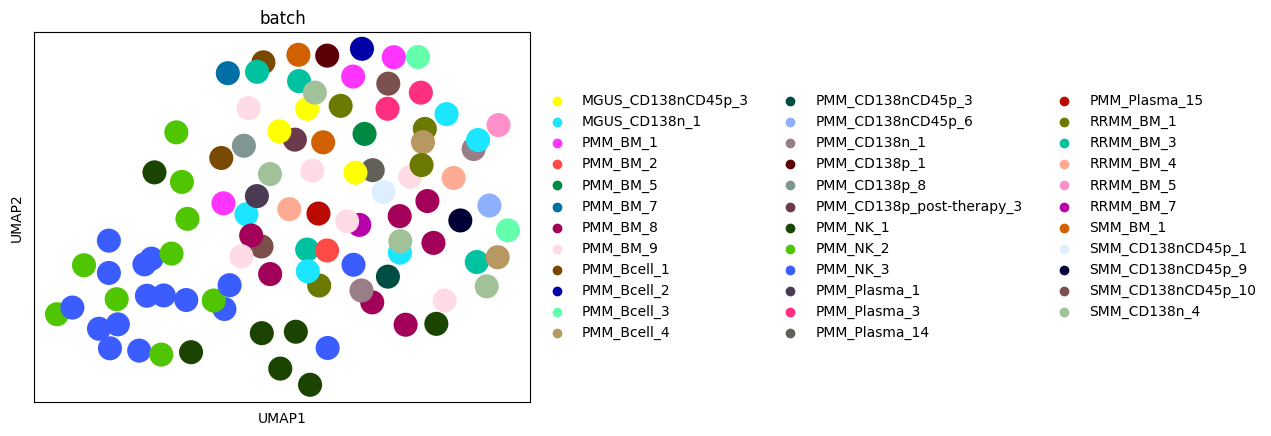

In [81]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )